instructions: https://www.cse.chalmers.se/~richajo/dit866/assignments/a3/assignment3.html

# Part 3 - Implementation

Then write a report detailing your implementation, your experiments and your analysis. In particular, some useful issues to discuss might include:

- How much consensus is there between annotators of the dataset? Do you think the data is reliable?

- Count those impossible, count this with full consensus, count those with less that full.  Define reliable, remove those unreliable according to the definition and use that clean and neat dataset for the next step.  

How do you represent your data as features?

- With a TfidfVectorizer (hold frequency as normalized data summing to one)

Did you process the features in any way?

- Mainly using Tdidfvectorizer hyperparameters. 

How did you select which learning algorithms to use?

Selection based on ...

- Did you try to tune the hyperparameters of the learning algorithm, and in that case how?

- How do you evaluate the quality of your system?

- How well does your system compare to a trivial baseline?

- Can you say anything about the errors that the system makes? For a classification task, you may consider a confusion matrix. It is also probably meaningful to include selected errors and comment on what might have gone wrong.

- Is it possible to say something about which features the model considers important? (Whether this is possible depends on the type of classifier you are using.)

## How much consensus is there between annotators of the dataset? Do you think the data is reliable?

Def reliable: consensus on the annotations, not impossible to decide stance (-1) on, 2-4 annotations. Despite lacking any control, annotation with only one entry 

In [ ]:
import pandas as pd
import numpy  as np
"""
Start off by filtering all instances with 2 annontations 
and without those that are impossible to annotate (-1) 
That is 30 644 instances with exact 2 annotations, and 32 053 with 2 or less. 

Some instances have as much as 33 annotations, pure duplicates indicate error of some sort
"""
comment_data = pd.read_csv('a3_train_final.tsv', sep='\t', header=None, names=['stance', 'comment'])

stances =[]
comments =[]
nr_agreements =0
i =0

# filter only good instances
for stance in comment_data["stance"]:
    lst = stance.split("/")
    if '-1' in lst:
        continue
    if (len(lst) >1 and len(lst) <5):
        
        s= set(lst)
        if (len(s)==1): # consensus
            nr_agreements +=1
            stances.append(s)
            comments.append(comment_data["comment"][i])
            #print(comment_data["comment"][i])
    i+=1

d = {'Stance':stances,'Comment':comments}
df = pd.DataFrame(d) 
#print(df)

      Stance                                            Comment
0        {1}   I'll only consume if I know what's inside it....
1        {0}   It is easier to fool a million people than it...
2        {1}   NATURAL IMMUNITY  protected us since evolutio...
3        {0}   NATURAL IMMUNITY  protected us since evolutio...
4        {1}   The bigest sideffect of vaccines is fewer dea...
...      ...                                                ...
30192    {0}  Yeah no thanks. I'll take my chances with the ...
30193    {0}    Yeah nope. Not shooting up some mystery vaccine
30194    {0}  Yeah only the scientist that are funded by Pfi...
30195    {0}  Yeah right Good luck with pushing that Johnson...
30196    {1}  Yeah right!! 143 deaths in UK shortly after va...

[30197 rows x 2 columns]


In [ ]:
# Check how many annotations are not annotated with -1
# Building on Jonas' code
import matplotlib.pyplot as plt

rows_with_minus_one = []
rows_not_in_consensus = []
rows_longer_than_2 = []
row = 0
for line in comment_data['stance']:
    annotations = line.split('/')

    if (len(annotations) > 2):
        rows_longer_than_2.append(row)
        row += 1
        continue

    if ('-1' in annotations):
        rows_with_minus_one.append(row)
        row += 1
        continue

    if len(set(annotations)) > 1:
        rows_not_in_consensus.append(row)
        row += 1
        continue
    
    row += 1

print(len(comment_data['stance']))
print(len(rows_with_minus_one))
print(rows_with_minus_one)
print(len(rows_longer_than_2))
print(len(rows_not_in_consensus))


37885
3466
[1, 3, 5, 8, 11, 15, 24, 34, 37, 41, 45, 52, 56, 57, 63, 72, 76, 77, 86, 95, 108, 110, 113, 130, 132, 143, 160, 161, 164, 165, 177, 180, 189, 192, 200, 203, 207, 213, 219, 226, 234, 252, 261, 282, 286, 319, 329, 347, 349, 351, 356, 365, 369, 372, 388, 390, 395, 397, 398, 401, 406, 417, 424, 445, 458, 459, 466, 472, 474, 475, 476, 481, 502, 530, 541, 542, 558, 565, 567, 594, 599, 605, 643, 650, 652, 655, 658, 673, 683, 687, 714, 786, 788, 793, 796, 798, 805, 825, 846, 848, 868, 870, 886, 890, 892, 902, 903, 912, 947, 961, 974, 975, 983, 1003, 1010, 1011, 1013, 1028, 1046, 1051, 1053, 1055, 1056, 1057, 1075, 1079, 1082, 1102, 1118, 1149, 1160, 1174, 1179, 1189, 1198, 1204, 1209, 1214, 1216, 1217, 1220, 1230, 1262, 1265, 1267, 1271, 1287, 1294, 1300, 1314, 1315, 1322, 1324, 1335, 1338, 1346, 1360, 1362, 1365, 1366, 1372, 1400, 1401, 1409, 1416, 1444, 1452, 1471, 1478, 1483, 1491, 1504, 1505, 1506, 1527, 1528, 1532, 1537, 1541, 1547, 1602, 1611, 1613, 1630, 1636, 1643, 1665, 166

94% agreement among the cleaned data with 2 values, but here we have duplicated those with one only. 

# w/ first data set

In [ ]:
comment_data = pd.read_csv('a3_first_sample.tsv', sep='\t', header=None, names=['stance', 'comment'])
print(len(comment_data)) # missing 25 values? 
comment_data.head()

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(
    comment_data.comment, comment_data.stance, test_size=0.2, random_state=12345)

975


In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
# try naive bayes? 

#try with different linear classifiers [SVC, KNN, SVC & ensemble] 
#best linearSVC: linearSVC() --> 0.73...
#best KNN: KNeighborsClassifier(n_neighbors=15,weights='distance') --> 0.7436
#best SVC: SVC() -->0.7077

def train_document_classifier(X, Y):
    pipeline = make_pipeline( TfidfVectorizer(), KNeighborsClassifier(n_neighbors=15,weights='distance')  )
    pipeline.fit(X, Y)
    return pipeline


In [ ]:
from sklearn.metrics import accuracy_score

clf = train_document_classifier(X_train, Y_train)
acc = accuracy_score(Y_test, clf.predict(X_test))
print("Accuracy score of: {:.4f} " .format(acc))

Accuracy score of: 0.7436 


ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of ticklabels (975).

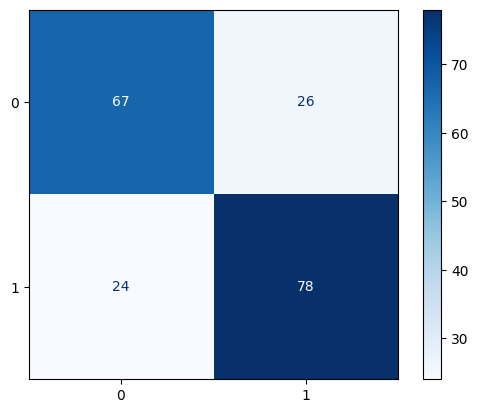

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_true = Y_test
y_pred = clf.predict(X_test)
#confusion_matrix(y_true, y_pred) # pure computation
class_names = comment_data.stance

titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]

for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        clf,
        X_test,
        Y_test,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

## initial testing of different vectorizers

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

Y = comment_data.stance

vectorizer1 = CountVectorizer()
X_v1 = vectorizer1.fit_transform(comment_data.comment)
vectorizer2 = TfidfVectorizer()
X_v2 = vectorizer2.fit_transform(comment_data.comment)

X_v1.shape #(975, 3343), same for both

(975, 3343)

In [ ]:
from sklearn.linear_model import Perceptron
from sklearn.model_selection import cross_val_score

# linear classifier 

cross_val_score(Perceptron(), X_v1, Y, cv=4).mean()

0.7333114079471093

['a', 'about', 'above', 'after', 'again', 'against', 'all', 'am', 'an', 'and', 'any', 'are', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', "can't", 'cannot', 'could', "couldn't", 'did', "didn't", 'do', 'does', "doesn't", 'doing', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', "hadn't", 'has', "hasn't", 'have', "haven't", 'having', 'he', "he'd", "he'll", "he's", 'her', 'here', "here's", 'hers', 'herself', 'him', 'himself', 'his', 'how', "how's", 'i', "i'd", "i'll", "i'm", "i've", 'if', 'in', 'into', 'is', "isn't", 'it', "it's", 'its', 'itself', "let's", 'me', 'more', 'most', "mustn't", 'my', 'myself', 'no', 'nor', 'not', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'ought', 'our', 'ours\tourselves', 'out', 'over', 'own', 'same', "shan't", 'she', "she'd", "she'll", "she's", 'should', "shouldn't", 'so', 'some', 'such', 'than', 'that', "that's", 'the', 'their', 'theirs', 'them', 'themselves', 'the

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f93a499e-42e4-47ba-a697-a51a595d57fe' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>